In [3]:
import pandas as pd
import numpy as np

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, SpatialDropout1D, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Activation, Dropout
# import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt

from imblearn.over_sampling import SMOTE
from collections import Counter



In [4]:
#Auxillary function for graphing loss and accuracy during training
def graph_plots(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.savefig(string + '.png')
  plt.show()

In [5]:
df = pd.read_csv('cleaned_dataset.csv')
df.columns

Index(['type', 'posts', 'cleaned_posts'], dtype='object')

In [6]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['cleaned_posts'])
tokenizer.word_index # Get our learned vocabulary
word_index = tokenizer.word_index

VOCAB_SIZE = len(word_index)+1 # Total words

In [7]:
X = tokenizer.texts_to_sequences(df['cleaned_posts'])
MAX_SEQ_LENGTH = max(len(seq) for seq in X)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen= MAX_SEQ_LENGTH) # Pad the sequence to the same length to make it uniform

In [8]:
labels = LabelEncoder().fit_transform(df.type)
n_classes = len(np.unique(labels))
n_classes


16

In [9]:
X.shape, labels.shape

((8675, 957), (8675,))

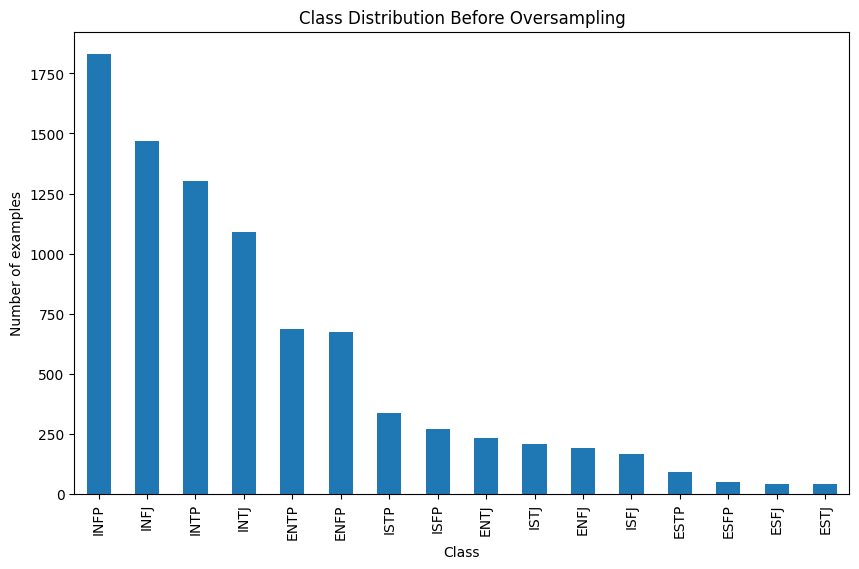

<Figure size 640x480 with 0 Axes>

In [10]:
plt.figure(figsize=(10, 6))
y = df.type
y.value_counts().plot(kind='bar')
plt.title('Class Distribution Before Oversampling')
plt.xlabel('Class')
plt.ylabel('Number of examples')
plt.show()
plt.savefig('class_distribution_before_oversampling.png')


In [9]:
y.value_counts()

type
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64

#### One hot encode the labels


In [11]:

y = pd.get_dummies(y)


#### Split data to train and test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42, shuffle=True)


In [13]:
smote = SMOTE(random_state=42, k_neighbors=3)
X_train, y_train = smote.fit_resample(X_train,y_train)
X_train.shape, y_train.shape


((23392, 957), (23392,))

In [14]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [17]:
X_train.shape, y_train.shape

((23392, 957), (23392, 16))

In [18]:
#oversample only training so we dont risk on testing on data that already is seen by the model???

In [19]:
embedding_size = 100
model_rnn = Sequential()
model_rnn.add(Embedding(VOCAB_SIZE, embedding_size, input_length= MAX_SEQ_LENGTH))
model_rnn.add(SimpleRNN(100))
model_rnn.add(Dense(n_classes, activation='softmax'))
model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history =model_rnn.fit(X_train,y_train, epochs =100, verbose=0,
                    validation_split = 0.1, 
                    callbacks=[
                        EarlyStopping(monitor='val_loss',
                                    patience=3,
                                    min_delta=1e-5)])



KeyboardInterrupt: 

In [50]:
model_path = "/Users/salmazainana/mbti-cs229/model_rnn.model"
model_rnn.save(model_path)

model_rnn = tf.keras.models.load_model('model_rnn.model')


In [51]:
#print(y_test)
y_pred = model_rnn.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_int = np.argmax(y_test.values, axis=1) # Convert one hot encoded y_test back to categorical
accuracy = accuracy_score(y_test_int, y_pred)
accuracy


55/55 [==============================] - 1s 23ms/step


0.07146974063400577

In [64]:
plt.savefig('losn and accuracy before oversampling.png')

<Figure size 640x480 with 0 Axes>

--------------------------------------- For embedding size of : 50


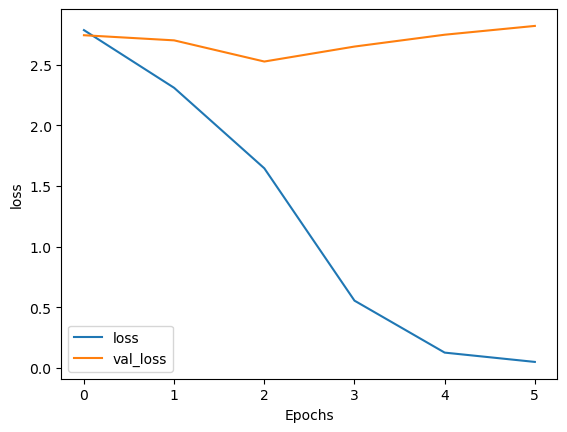

24/24 [==============================] - 2s 63ms/step
--------------------------------------- For embedding size of : 100


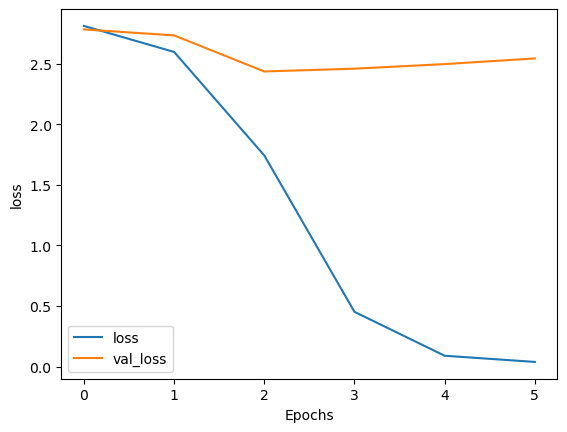

24/24 [==============================] - 2s 77ms/step
--------------------------------------- For embedding size of : 200


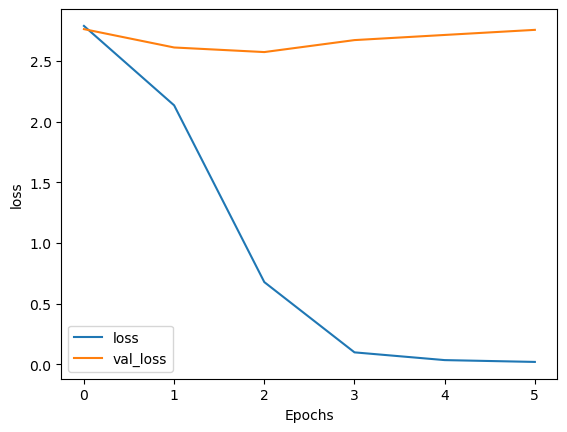

24/24 [==============================] - 2s 85ms/step
--------------------------------------- For embedding size of : 300


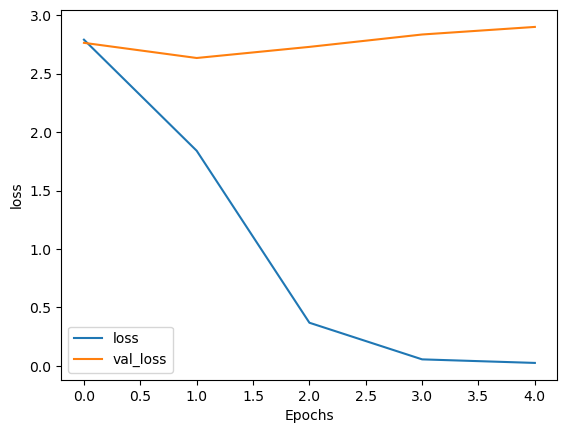

24/24 [==============================] - 4s 172ms/step


In [41]:
# Simple RNN - baseline model with labels only encoded from 1-16 
sizes = [50, 100, 200, 300]
for embedding_size in sizes:
  model_rnn = Sequential()
  model_rnn.add(Embedding(VOCAB_SIZE, embedding_size, input_length= MAX_SEQ_LENGTH))
  model_rnn.add(SimpleRNN(100))
  model_rnn.add(Dense(n_classes, activation='softmax'))
  model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  history =model_rnn.fit(X_train,y_train, epochs =100, verbose=0,
                        validation_split = 0.1, 
                        callbacks=[
                          EarlyStopping(monitor='val_loss',
                                        patience=3,
                                        min_delta=1e-5)])
  print('--------------------------------------- For embedding size of :', embedding_size)
  #graph_plots(history, "accuracy")
  graph_plots(history, "loss")
  y_pred = model_rnn.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)
  accuracy = accuracy_score(y_test, y_pred)

In [ ]:
plt.savefig('loss and accuracy after oversampling.png')

In [ ]:
# RNN with dropout layers
sizes = [50, 100, 200, 300]
dropout_rates=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
for embedding_size in sizes:
  for rate in dropout_rates:
    model_rnn = Sequential()
    model_rnn.add(Embedding(VOCAB_SIZE, embedding_size, input_length= MAX_SEQ_LENGTH))
    model_rnn.add(SimpleRNN(100))
    model_rnn.add(Dropout(rate))
    model_rnn.add(Dense(n_classes, activation='softmax'))
    model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history =model_rnn.fit(X_train,y_train, epochs =100, verbose=0,
                            validation_split = 0.1, 
                            callbacks=[
                            EarlyStopping(monitor='val_loss',
                                            patience=3,
                                            min_delta=1e-5)])
    print('------------------------- For embedding size of :', embedding_size, 'and dropout rate of :', rate)
    graph_plots(history, "accuracy")
    graph_plots(history, "loss")
    y_pred = model_rnn.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_test, y_pred)

In [42]:
# RNN with dropout layers and one hot encoded labels


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
results = []
y_one_hot = pd.get_dummies(y_res)   # One hot encode the target variable
X_train, X_test, y_train, y_test = train_test_split(X_res, y_one_hot, test_size=0.2, random_state=1234)
sizes = [50, 100, 200, 300]
dropout_rates=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
for embedding_size in sizes:
  for rate in dropout_rates:
    model_rnn2 = Sequential()
    model_rnn2.add(Embedding(VOCAB_SIZE, embedding_size, input_length= MAX_SEQ_LENGTH))
    model_rnn2.add(SimpleRNN(100))
    #if LSTM == True:
    #  model_rnn2.add(LSTM(100,dropout =rate, recurrent_dropout=rate))
    #else:
    model_rnn2.add(Dropout(rate))
    model_rnn2.add(Dense(n_classes, activation='softmax'))
    model_rnn2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history =model_rnn2.fit(X_train,y_train,
                          epochs =100, verbose=0,
                          validation_split = 0.01,
                          callbacks=[
                            EarlyStopping(monitor='val_loss',
                                          patience=3,
                                          min_delta=1e-5)])
    print('--------------------------------------- For dropout rate of :', rate)
    y_pred = model_rnn2.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test_int = np.argmax(y_test.values, axis=1) # Convert one hot encoded y_test back to categorical
    accuracy = accuracy_score(y_test_int, y_pred)
    precision = precision_score(y_test_int, y_pred, average='weighted')
    recall = recall_score(y_test_int, y_pred, average='weighted')
    f1 = f1_score(y_test_int, y_pred, average='weighted')
        
    results.append({
        'embedding_size': embedding_size,
        'dropout_rate': rate,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

    # graph_plots(history, "loss")
    # graph_plots(history, "accuracy")

--------------------------------------- For dropout rate of : 0.1
24/24 [==============================] - 2s 68ms/step


/Users/zainanasalma/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------- For dropout rate of : 0.2
24/24 [==============================] - 2s 58ms/step


/Users/zainanasalma/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------- For dropout rate of : 0.3
24/24 [==============================] - 2s 70ms/step
--------------------------------------- For dropout rate of : 0.4
24/24 [==============================] - 1s 49ms/step
--------------------------------------- For dropout rate of : 0.5
24/24 [==============================] - 1s 46ms/step


/Users/zainanasalma/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------- For dropout rate of : 0.6
24/24 [==============================] - 1s 50ms/step


/Users/zainanasalma/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------- For dropout rate of : 0.7
24/24 [==============================] - 1s 50ms/step


/Users/zainanasalma/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------- For dropout rate of : 0.8
24/24 [==============================] - 2s 56ms/step


/Users/zainanasalma/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------- For dropout rate of : 0.1
24/24 [==============================] - 1s 40ms/step
--------------------------------------- For dropout rate of : 0.2
24/24 [==============================] - 1s 38ms/step
--------------------------------------- For dropout rate of : 0.3
24/24 [==============================] - 1s 39ms/step
--------------------------------------- For dropout rate of : 0.4
24/24 [==============================] - 1s 49ms/step


/Users/zainanasalma/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------- For dropout rate of : 0.5
24/24 [==============================] - 1s 45ms/step


/Users/zainanasalma/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------- For dropout rate of : 0.6
24/24 [==============================] - 1s 42ms/step


/Users/zainanasalma/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------- For dropout rate of : 0.7
24/24 [==============================] - 1s 46ms/step


/Users/zainanasalma/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------- For dropout rate of : 0.8
24/24 [==============================] - 1s 38ms/step


/Users/zainanasalma/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------- For dropout rate of : 0.1
24/24 [==============================] - 1s 46ms/step


/Users/zainanasalma/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------- For dropout rate of : 0.2
24/24 [==============================] - 1s 45ms/step
--------------------------------------- For dropout rate of : 0.3
24/24 [==============================] - 1s 46ms/step


/Users/zainanasalma/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------- For dropout rate of : 0.4
24/24 [==============================] - 1s 47ms/step
--------------------------------------- For dropout rate of : 0.5
24/24 [==============================] - 1s 47ms/step
--------------------------------------- For dropout rate of : 0.6
24/24 [==============================] - 1s 54ms/step


/Users/zainanasalma/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------- For dropout rate of : 0.7
24/24 [==============================] - 1s 47ms/step
--------------------------------------- For dropout rate of : 0.8
24/24 [==============================] - 1s 47ms/step
--------------------------------------- For dropout rate of : 0.1
24/24 [==============================] - 3s 102ms/step
--------------------------------------- For dropout rate of : 0.2
24/24 [==============================] - 2s 98ms/step
--------------------------------------- For dropout rate of : 0.3
24/24 [==============================] - 3s 100ms/step


/Users/zainanasalma/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------- For dropout rate of : 0.4
24/24 [==============================] - 3s 102ms/step
--------------------------------------- For dropout rate of : 0.5
24/24 [==============================] - 3s 101ms/step
--------------------------------------- For dropout rate of : 0.6
24/24 [==============================] - 3s 102ms/step


/Users/zainanasalma/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------- For dropout rate of : 0.7
24/24 [==============================] - 3s 109ms/step


/Users/zainanasalma/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--------------------------------------- For dropout rate of : 0.8
24/24 [==============================] - 3s 102ms/step


In [44]:
results = pd.DataFrame(results)

In [72]:
#print results with samples from highest accuracy to lowest
results.sort_values('accuracy', ascending=False)

,embedding_size,dropout_rate,accuracy,precision,recall,f1_score
24,300,0.1,0.242424,0.236683,0.242424,0.235008
31,300,0.8,0.241107,0.238548,0.241107,0.234793
9,100,0.2,0.220026,0.222902,0.220026,0.215639
27,300,0.4,0.220026,0.225083,0.220026,0.216399
17,200,0.2,0.202899,0.191059,0.202899,0.193916
20,200,0.5,0.196311,0.185158,0.196311,0.185534
19,200,0.4,0.196311,0.192628,0.196311,0.190896
23,200,0.8,0.194993,0.187057,0.194993,0.189005
3,50,0.4,0.194993,0.202227,0.194993,0.191864
10,100,0.3,0.191041,0.177187,0.191041,0.178852


In [29]:
# Xtrain and y train are the oversampled data
# LSTM with dropout layers and one hot encoded labels and one hot encoded labels oversampled for training onlu
rate = 0.8
embedding_size = 300
best_model = Sequential()
best_model.add(Embedding(VOCAB_SIZE, embedding_size, input_length= MAX_SEQ_LENGTH))
best_model.add(LSTM(100,dropout =rate, recurrent_dropout=rate))
best_model.add(Dropout(rate))
best_model.add(Dense(n_classes, activation='softmax'))
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history =best_model.fit(X_train,y_train,
                        epochs =100, verbose=0,
                        validation_split = 0.01,
                        callbacks=[
                        EarlyStopping(monitor='val_loss',
                                        patience=3,
                                          min_delta=1e-5)])
graph_plots(history, "loss")
graph_plots(history, "accuracy")

In [1]:

best_model = Sequential()
best_model.add(Embedding(VOCAB_SIZE, embedding_size, input_length= MAX_SEQ_LENGTH))
best_model.add(LSTM(100,dropout =rate, recurrent_dropout=rate))
best_model.add(Dropout(rate))
best_model.add(Dense(n_classes, activation='softmax'))
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history =best_model.fit(X_train,y_train,
                        epochs =100, verbose=0,
                        validation_split = 0.01,
                        callbacks=[
                        EarlyStopping(monitor='val_loss',
                                        patience=3,
                                          min_delta=1e-5)])
graph_plots(history, "loss")
graph_plots(history, "accuracy")

NameError: name 'Sequential' is not defined

# REGULIZERS WITH OVERSAMPLING 



In [1]:
from keras import regularizers


/Users/salmazainana/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42, shuffle=True)
smote = SMOTE(random_state=42, k_neighbors=3)
X_train, y_train = smote.fit_resample(X_train,y_train)
X_train.shape, y_train.shape
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

## L2 

In [17]:

rate1 = 0.8
rate2 = 0.8
size = 300

model_rnn = Sequential()
model_rnn.add(Embedding(VOCAB_SIZE, size, embeddings_regularizer=regularizers.l2(0.01), input_length= MAX_SEQ_LENGTH))
model_rnn.add(Dropout(rate1))
model_rnn.add(SimpleRNN(100, kernel_regularizer=regularizers.l2(0.01)))
model_rnn.add(Dropout(rate2))
model_rnn.add(Dense(n_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))
model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# history =model_rnn.fit( X_train,y_train,
#                       epochs =10, batch_size = 64, verbose=0,
#                       validation_split = 0.2,
#                       callbacks=[
#                         EarlyStopping(monitor='val_loss',
#                                       patience=10,
#                                        min_delta=1e-5)])


# print('--------------------------------------- For Embedding size', size, 'and dropout rate of :', rate1, 'and', rate2)
# y_pred = model_rnn.predict(X_test)
# y_pred = np.argmax(y_pred, axis=1)
# y_test_int = np.argmax(y_test.values, axis=1) # Convert one hot encoded y_test back to categorical
# accuracy = accuracy_score(y_test_int, y_pred)
# print("Accuracy:", accuracy)
# #graph_plots(history, "accuracy")
# graph_plots(history, "loss")

In [18]:
# model_rnn.save('model_rnn_l2_simple.h5')

## Grid Search

In [20]:
# !pip3 install keras-tuner


In [21]:
import keras_tuner as kt

In [29]:
def build_model(hp):
    embedding_size = 300
    dropout_rate1 = hp.Float('dropout_rate', min_value=0.1, max_value=0.9, step=0.1)
    dropout_rate2 = hp.Float('dropout_rate', min_value=0.1, max_value=0.9, step=0.1)
    l2_rate = hp.Float('l2_rate', min_value=0.0, max_value=0.01, step=0.001)

    model_rnn = Sequential([
        Embedding(VOCAB_SIZE, size, embeddings_regularizer=regularizers.l2(l2_rate), input_length= MAX_SEQ_LENGTH),
        Dropout(dropout_rate1),
        SimpleRNN(100, kernel_regularizer=regularizers.l2(l2_rate)),
        Dropout(dropout_rate2), 
        Dense(n_classes, activation='softmax', kernel_regularizer=regularizers.l2(l2_rate))
        ])
    
    model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model_rnn


# history =model_rnn.fit( X_train,y_train,
#                       epochs =10, batch_size = 64, verbose=0,
#                       validation_split = 0.2,
#                       callbacks=[
#                         EarlyStopping(monitor='val_loss',
#                                       patience=10,
#                                        min_delta=1e-5)])
    


In [30]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Set to a reasonable number to limit search time
    executions_per_trial=1,  # How many models to build for each trial
    directory='/Users/salmazainana/mbti-cs229',  # Directory where the search results will be saved
    project_name='keras_tuner_demo'
)

Reloading Tuner from /Users/salmazainana/mbti-cs229/keras_tuner_demo/tuner0.json


In [31]:
tuner.search(X_train, y_train, 
             epochs=10, 
             batch_size= 50,
             validation_split = 0.2, 
             callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=1e-4)])


Trial 15 Complete [00h 33m 43s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 07h 51m 40s


In [32]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.get_best_models(num_models=1)[0]

model.save('best_model_l2.h5')


/Users/salmazainana/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_int = np.argmax(y_test.values, axis=1) # Convert one hot encoded y_test back to categorical
accuracy = accuracy_score(y_test_int, y_pred)
print("Accuracy:", accuracy)

55/55 [==============================] - 3s 49ms/step
Accuracy: 0.10778097982708934
